## Day 14

https://adventofcode.com/2024/day/14

### Part 1

In [1]:
import re

def read_input_14(filename):
    f = open(filename)
    robots = []
    for l in f.readlines():
        x = [int(d) for d in re.findall(r"[-+]?\d+",l)]
        p = x[0]+x[1]*1j
        v = x[2]+x[3]*1j
        robots.append((p,v))
    return robots

def move_robots(robots,xmax,ymax):
    newrobots = []
    for p,v in robots:
        p1 = p+v
        x = p1.real
        y = p1.imag
        if x<0: x+=xmax
        if x>=xmax: x-=xmax
        if y<0: y+=ymax
        if y>=ymax: y-=ymax
        newrobots.append((x+y*1j,v))
    return newrobots

def evolve_robots(robots,xmax,ymax,nsec=1):
    for i in range(nsec):
        newrobots = move_robots(robots,xmax,ymax)
        robots = newrobots
    return robots

import numpy as np

def robots_to_grid(robots,xmax,ymax):
    grid = np.zeros((ymax,xmax),dtype=int)
    for p,v in robots:
        x = int(p.real)
        y = int(p.imag)
        grid[y,x] += 1
    return grid

def safety_factor(grid,xmax,ymax):
    sf = 1
    for g in [ 
        grid[:(ymax-1)//2,:(xmax-1)//2],
        grid[:(ymax-1)//2,(xmax-1)//2+1:],
        grid[(ymax-1)//2+1:,:(xmax-1)//2],
        grid[(ymax-1)//2+1:,(xmax-1)//2+1:]
    ]:
        sf *= sum(sum(g))
    return sf

def part1(filename,xmax,ymax):
    robots = read_input_14(filename)
    robots_end = evolve_robots(robots,xmax,ymax,nsec=100)
    grid_end = robots_to_grid(robots_end,xmax,ymax)
    return safety_factor(grid_end,xmax,ymax)

In [22]:
print("Test 1:",part1("examples/example14.txt",11,7))
print("Part 1:",part1("AOC2024inputs/input14.txt",101,103))

Test 1: 12
Part 1: 229632480


## Part 2

From the look puzzle, I was expecting to have to find a repetition in the robot configurations, or to compute the status after a very large number of iterations (thus having to estimate periods for all robots, then a common period). Instead, we got an Easter egg ;-)

### First approach

Scan a large number of configurations by eye...

In [5]:
import matplotlib.pyplot as plt

filename = "AOC2024inputs/input14.txt"
robots = read_input_14(filename)
xmax = 101
ymax = 103

npad = 0
for i in range(10000):

    if i%100==0:
        fig, axs = plt.subplots(10,10,figsize=(10,10),dpi=600)
        plt.gca()
        axi = 0
        axj = 0
        
    newrobots = move_robots(robots,xmax,ymax)
    robots = newrobots
    grid = robots_to_grid(robots,xmax,ymax)
    axs[axj,axi].set_title(f"{i+1}",fontsize=6,pad=0)
    axs[axj,axi].set_axis_off()
    axs[axj,axi].imshow(grid)
    axi+=1
    if axi==10:
        axi=0
        axj+=1

    if i%100==99:
        npad+=1
        plt.savefig(f"visualisation/day14_part2_{str(npad).zfill(3)}.png")
        plt.close('all')

My Easter egg is at second 7051:

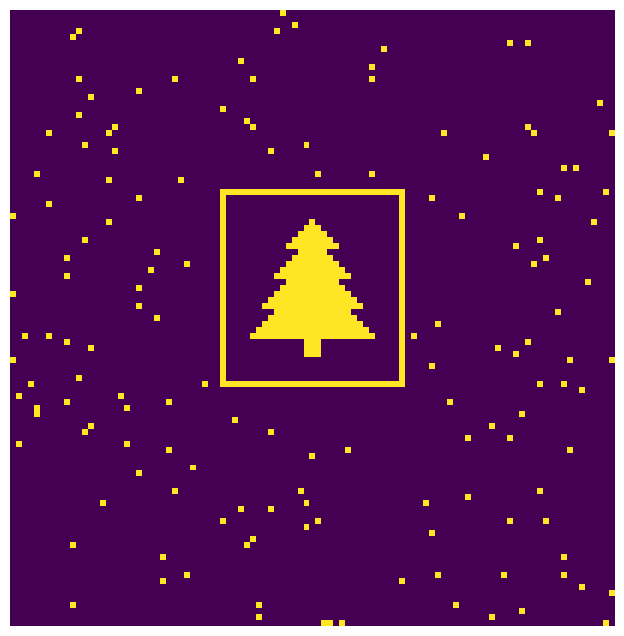

In [42]:
filename = "AOC2024inputs/input14.txt"
robots = read_input_14(filename)
xmax = 101
ymax = 103

for i in range(7051):        
    newrobots = move_robots(robots,xmax,ymax)
    robots = newrobots

grid = robots_to_grid(robots,xmax,ymax)

fig, ax = plt.subplots(figsize=(8,8),dpi=100)
plt.gca()
ax.set_axis_off()
plt.imshow(grid)
plt.savefig("visualisation/day14_easteregg.png")

### Second approach

Look for frame where there's no overlapping robot, assuming the Earstern egg frame has only one robot per position has been evolved backward, and there are always a few collisions in all others:

7051


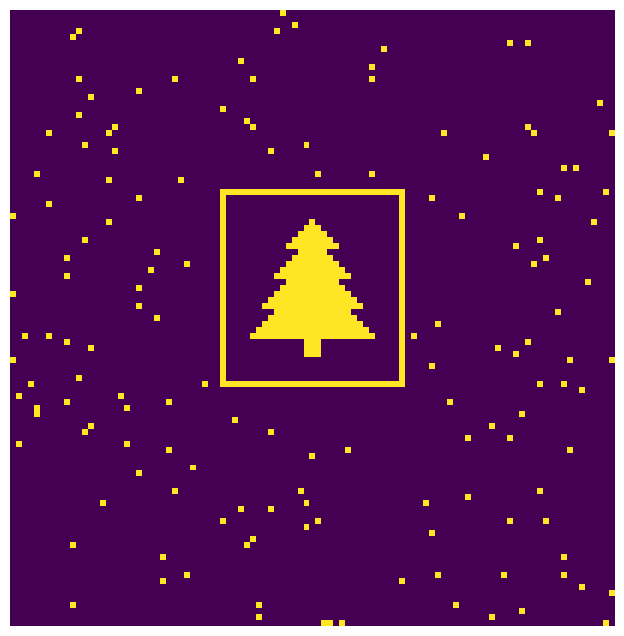

In [43]:
filename = "AOC2024inputs/input14.txt"
robots = read_input_14(filename)
xmax = 101
ymax = 103

i = 0
while True:        
    i += 1
    newrobots = move_robots(robots,xmax,ymax)
    grid = robots_to_grid(newrobots,xmax,ymax)
    if sum(grid[grid==1])==len(robots):
        print(i)
        break
    robots = newrobots

fig, ax = plt.subplots(figsize=(8,8),dpi=100)
plt.gca()
ax.set_axis_off()
plt.imshow(grid)

### Third approach

Computing image entropy

https://stackoverflow.com/questions/50313114/what-is-the-entropy-of-an-image-and-how-is-it-calculated

In [73]:
import numpy as np

def entropy(img):
    marg = np.histogramdd(np.ravel(img), bins = 256)[0]/img.size
    marg = list(filter(lambda p: p > 0, np.ravel(marg)))
    entropy = -np.sum(np.multiply(marg, np.log2(marg)))
    return entropy

filename = "AOC2024inputs/input14.txt"
robots = read_input_14(filename)
xmax = 101
ymax = 103

entropies = []
for i in range(10000):        
    newrobots = move_robots(robots,xmax,ymax)
    grid = robots_to_grid(newrobots,xmax,ymax)
    entropies.append(entropy(grid))
    robots = newrobots

7051


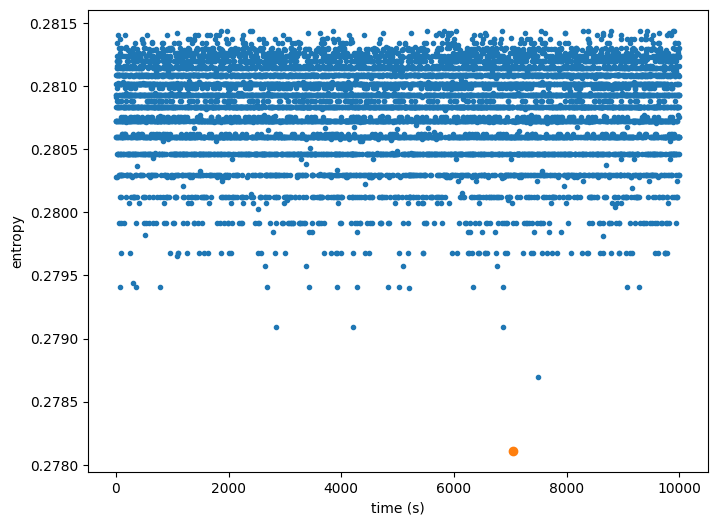

In [75]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)

plt.plot([i+1 for i in range(10000)],entropies,linestyle="",marker=".")

ax.set_xlabel("time (s)")
ax.set_ylabel("entropy")

easter_egg = entropies.index( min(entropies) )+1
plt.plot(easter_egg,entropies[easter_egg-1],linestyle="",marker="o")

print(easter_egg)